In [7]:
from lmfit.models import LorentzianModel, ConstantModel
from init import *
decays = (
    natural_decay_ops_D1() +
    quenching_ops("D1") +
    wall_coll("D1", gamma=1e3)
    # + dephasing_excited_states("D1", gamma=1e7) +
    # dephasing_ground_states_D1()
)


def hamil(
        mw_det,
        b_longitudinal=0.1,
        mw_mag_field=1e-2,
        laser_intens=OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL/5):

    # Atom-field Hamiltonian
    # sigma_plus
    ham_laser_atom = H_atom_field_D1(-1, E_0_plus(laser_intens)).full()
    # ham_laser_atom[8:11, :] = 0
    # ham_laser_atom[:, 8:11] = 0
    ham_laser_atom[:3, :] = 0       # F=1 -> F' neglected
    ham_laser_atom[:, :3] = 0
    # Hyperfine Structure with Zeeman levels
    hb0 = H_hfs_ground() + H_B(bz=b_longitudinal)
    eigvals, eigstates = hb0.eigenstates()
    F_states_reordered = [
        eigstates[2],
        eigstates[1],
        eigstates[0],
    ]
    for k in range(3, 3 + 5):
        F_states_reordered.append(eigstates[k])
    # Atom Hamiltonian in rotating frame
    ham_atom = H_atom(det_Light=0, line="D1").full()
    ham_atom[:8, :8] = hb0.transform(F_states_reordered).tidyup(atol=1e-3)
    ham_atom[8:, 8:] = hb0.transform(F_states_reordered).tidyup(
        atol=1e-3)/3   # for excited state: g'_F = g_F / 3
    diff_f2_fp1 = ham_atom[9, 9] - ham_atom[5, 5]
    for k in range(8, 16):
        # laser resonant to F=2 m_F=0 to F'=1, m'_F=0
        ham_atom[k, k] -= diff_f2_fp1

    diff_f2_f1 = (ham_atom[5, 5]-ham_atom[1, 1])
    for k in range(3):
        ham_atom[k, k] += diff_f2_f1  # rotating frame mw

    # for k in range(8, 11):
    #     ham_atom[k, k] = 0      # we ignore F'=1
    # for k in range(11, 16):
    #     # laser resonant to all Zeeman levels
    #     ham_atom[k, k] = ham_atom[k-8, k-8]
    hb_ac = H_B(bx=mw_mag_field/2**0.5, by=mw_mag_field/2 **
                0.5).transform(F_states_reordered).tidyup(atol=1e-3)  # transverse MW field
    hb_ac = hb_ac.full()
    for i in range(7):  # RWA
        hb_ac[i, i + 1] = 0.0
        hb_ac[i + 1, i] = 0.0
    h_a_mw = np.zeros(shape=(16, 16), dtype=np.cdouble)
    h_a_mw[:8, :8] = hb_ac

    ham_tot = ham_atom + h_a_mw + ham_laser_atom
    for k in range(3):
        ham_tot[k, k] += mw_det
    offset = ham_tot[1, 1]
    for k in range(16):
        ham_tot[k, k] -= offset
    return Qobj(ham_tot).tidyup(atol=1e-3)


def faraday_rot_angle(rho):
    wavelength_probe_laser = 780e-9
    density_atoms = 2.33e12 / (1e-2)**3
    length_cell = 2e-3
    detunings_probe = [-30e9 * 2*pi, (-30e9-6.834682e9) * 2*pi]
    return (
        sum([mF * (-1)**F * rho.matrix_element(get_ket_Fg_D1(F, mF).dag(), get_ket_Fg_D1(F, mF)) / detunings_probe[F-1]
            for F in (1, 2) for mF in range(-F, F + 1)]).real
        * density_atoms*length_cell
        * wavelength_probe_laser**2
        * GAMMA_RAD_D2
        * 0.5
    )


def P_loop(b_mw, radius=0.7e-2, distance=0.03):
    return (
        b_mw * 1e-4
        * (constants.mu_0
            * radius**2
            / (2 * (distance**2 + radius**2) ** (3 / 2)))**(-1)
    )**2 * 50


In [8]:
laser_intens = OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL/10
b_longitudinal = 0.1
Bmw = 1e-3
ham_tot = hamil(0, b_longitudinal=b_longitudinal,
                laser_intens=laser_intens, mw_mag_field=Bmw)
laser_ss = steadystate(
    hamil(0, b_longitudinal=b_longitudinal,
          laser_intens=laser_intens, mw_mag_field=0),
    c_op_list=decays
)
mw_detunings = np.linspace(ham_tot[3, 3] - ham_tot[0, 0] - 500e3*2*pi,
                           ham_tot[7, 7] - ham_tot[2, 2] + 500e3*2*pi,
                           201)

resonant_mw_freqs = [b_longitudinal * 0.7e3 *
                     k for k in range(-3, 3+1)]   # 7 different transition frequencies                           

10.0%. Run time:   9.62s. Est. time left: 00:00:01:26
20.0%. Run time:  19.17s. Est. time left: 00:00:01:16
30.0%. Run time:  28.96s. Est. time left: 00:00:01:07
40.0%. Run time:  38.65s. Est. time left: 00:00:00:57
50.0%. Run time:  48.26s. Est. time left: 00:00:00:48
60.0%. Run time:  57.85s. Est. time left: 00:00:00:38
70.0%. Run time:  67.48s. Est. time left: 00:00:00:28
80.0%. Run time:  77.13s. Est. time left: 00:00:00:19
90.0%. Run time:  86.89s. Est. time left: 00:00:00:09
Total run time:  96.58s


(<Figure size 1200x600 with 10 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='Time (s)'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

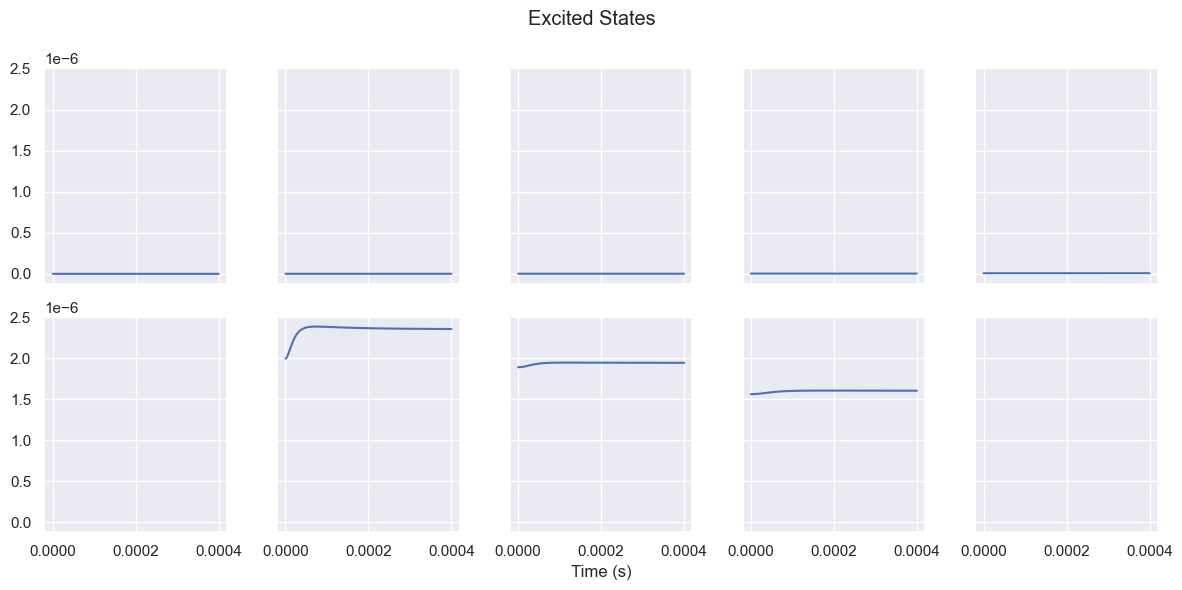

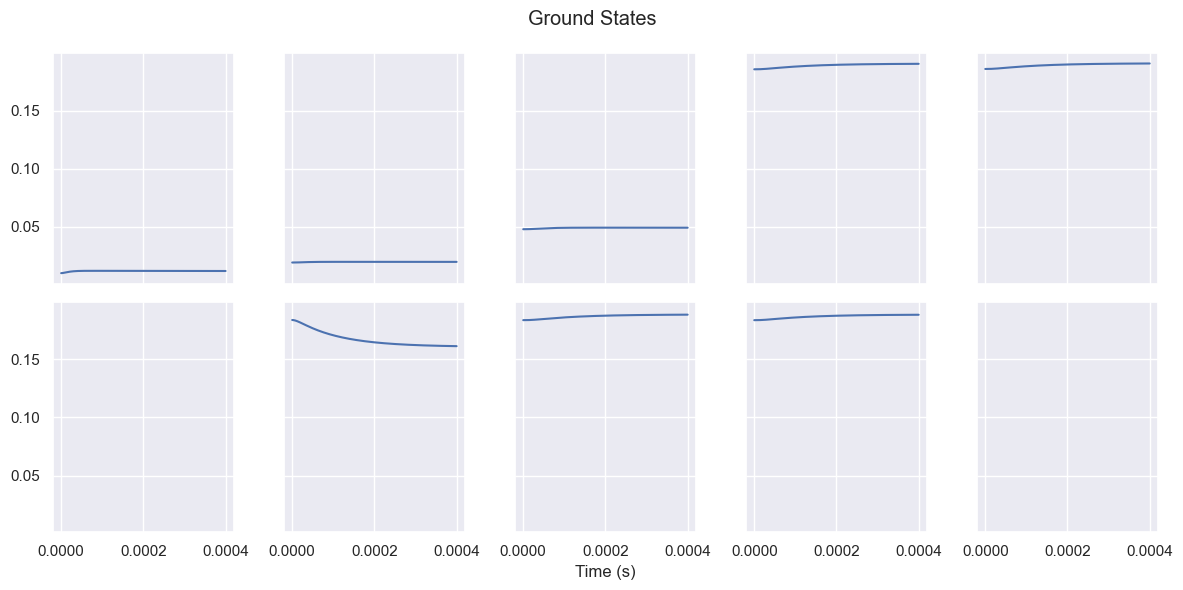

In [10]:
mw_detuning = (ham_tot[3, 3] - ham_tot[0, 0])
h = hamil(mw_detuning,
          b_longitudinal, 
          laser_intens=laser_intens, 
          mw_mag_field=Bmw)
time_evo_options = Options(nsteps=2**5 * 1000)
res = mesolve(
    h,
    rho0=laser_ss,
    tlist=np.linspace(0, 4e-4, 2000),
    c_ops=decays,
    options=time_evo_options,
    progress_bar=True
)
plot_excited_states_time(res)
plot_ground_states_time(res)


In [9]:


def run_simulation_exp(
        mw_magnetic_field,
        laser_intens=OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL/10,
        ):
    rho_steady_list = [
        steadystate(hamil(det, b_longitudinal, laser_intens=laser_intens, mw_mag_field=mw_magnetic_field),
                    c_op_list=decays, method="direct")
        for det in mw_detunings
    ]
    return rho_steady_list


def get_excited_state_pops(rho_list) -> List:
    return [sum(state.diag()[8:]) for state in rho_list]


def fit_simulation(excited_state_pops: List):
    from lmfit.models import LorentzianModel, ConstantModel
    models = [LorentzianModel(prefix=f"p{ind}_") for ind in (1, 2, 3)]
    mod = ConstantModel()
    for m in models:
        mod = mod + m
    pars = mod.make_params(p1_center=resonant_mw_freqs[0],
                           p2_center=resonant_mw_freqs[2],
                           p3_center=resonant_mw_freqs[4],
                           p1_amplitude=5.8635e-04,
                           p2_amplitude=5.5343e-04,
                           p3_amplitude=4.3310e-04,
                           p1_sigma=10.0427174,
                           p2_sigma=11.8743714,
                           p3_sigma=10.5537300,	
                           c=2.3210e-05)
    res = mod.fit(data=excited_state_pops,
                  params=pars, x=mw_detunings/(2e3*pi))
    return res

In [4]:
magnetic_fields = np.linspace(1e-5, 1e-4, 10)
spectra_steady = [run_simulation_exp(b) for b in magnetic_fields]
# spectra_steady = parallel_map(run_simulation_exp, magnetic_fields)

In [5]:
exc_states = [get_excited_state_pops(elem) for elem in spectra_steady]

In [6]:
fit_results = [fit_simulation(exc) for exc in exc_states]

In [7]:
d=dict([(key, []) for key in fit_results[-1].params.keys()])
for result in fit_results:
    for key in result.params.keys():
        d[key].append(result.params[key].value)
import pandas as pd
res_df = pd.DataFrame(d)

c:\Users\m\anaconda3\envs\masterarbeit_python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


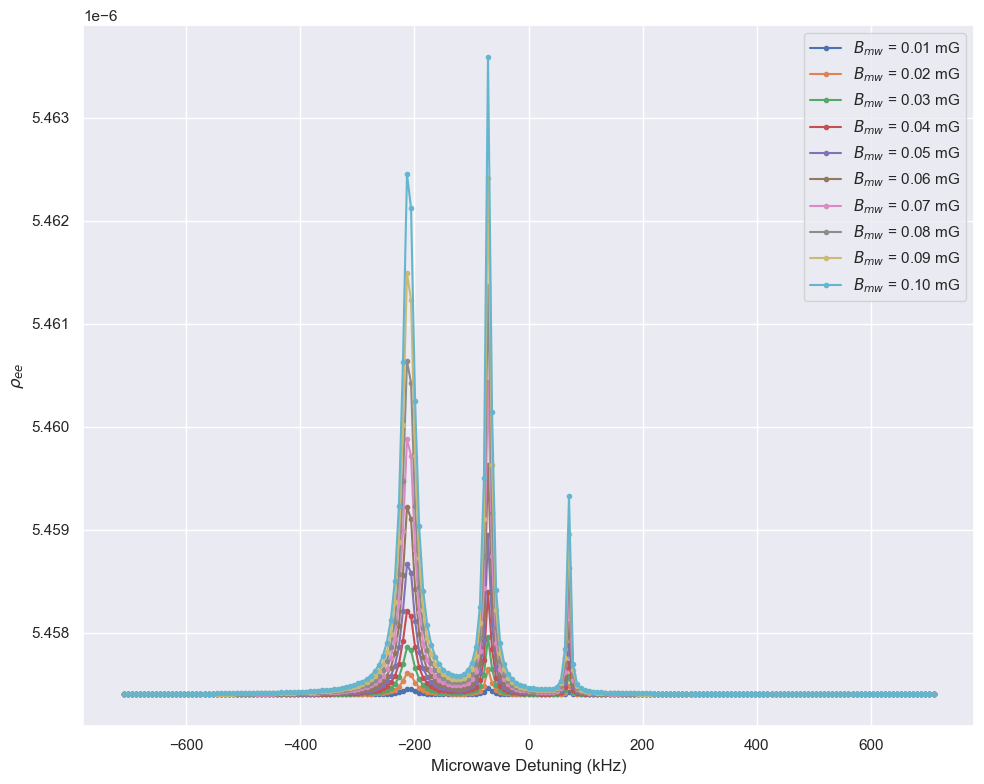

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
for ind in range(len(exc_states)):
    ax.plot(mw_detunings/(2e3*pi), exc_states[ind], label=fr"""$B_{{mw}}$ = {magnetic_fields[ind]*1e3:.2f} mG""", marker=".")
ax.set_xlabel(r"Microwave Detuning (kHz)")
ax.set_ylabel(r"$\rho_{ee}$")
plt.legend()
plt.tight_layout()
# fig.savefig("rho_ee.png")

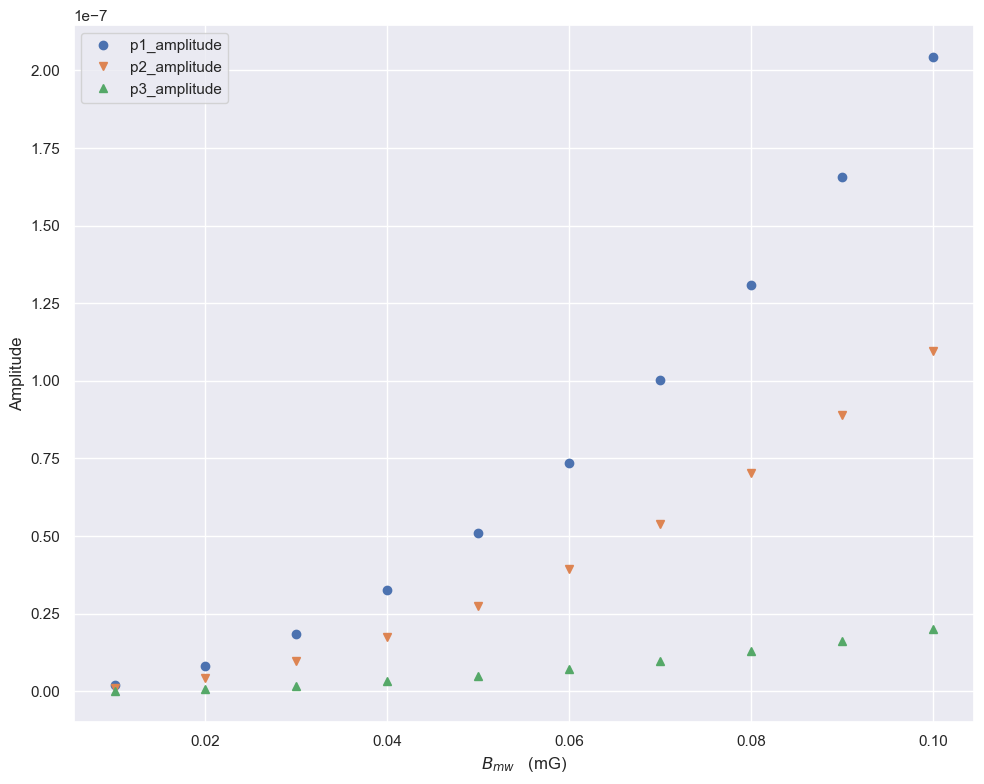

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([b*1000 for b in magnetic_fields], res_df["p1_amplitude"], "o")
ax.plot([b*1000 for b in magnetic_fields], res_df["p2_amplitude"], "v")
ax.plot([b*1000 for b in magnetic_fields], res_df["p3_amplitude"], "^")
plt.xlabel(r"$B_{mw}$   (mG)")
plt.ylabel(r"Amplitude")
plt.legend(["p1_amplitude", "p2_amplitude", "p3_amplitude"])
plt.tight_layout()
# fig.savefig("amplitudes sim.png")

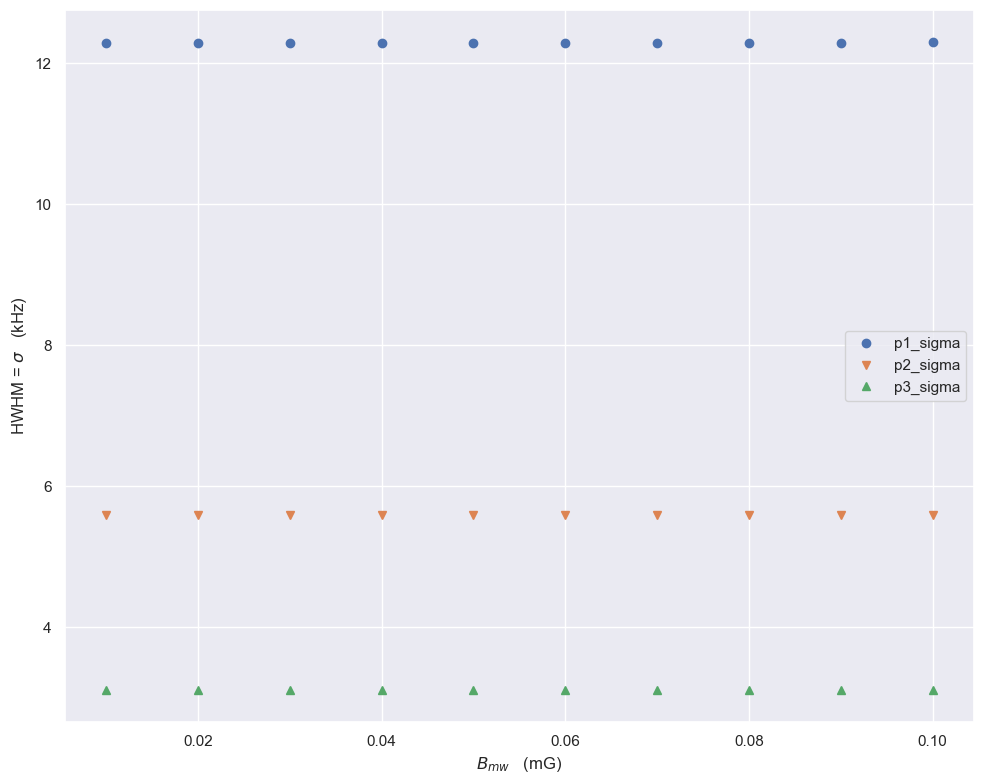

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([b*1000 for b in magnetic_fields], res_df["p1_sigma"], "o")
ax.plot([b*1000 for b in magnetic_fields], res_df["p2_sigma"], "v")
ax.plot([b*1000 for b in magnetic_fields], res_df["p3_sigma"], "^")
plt.xlabel(r"$B_{mw}$   (mG)")
plt.ylabel(r"HWHM = $\sigma$   (kHz)")
plt.legend(["p1_sigma", "p2_sigma", "p3_sigma"])
plt.tight_layout()
# fig.savefig("sigma sim.png")

In [32]:
fit_results[2]

In [11]:
res_df["p1_amplitude"]/res_df["p3_amplitude"]

0    10.139976
1    10.141391
2    10.141692
3    10.141563
4    10.141504
5    10.141252
6    10.141202
7    10.141014
8    10.140707
9    10.140527
dtype: float64

In [12]:
hamil(0, b_longitudinal, laser_intens=laser_intens, mw_mag_field=1e-3)

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 4.41313225e+05   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          5.39413388e+03-5394.13388249j
   0.00000000e+00   +0.j         -2.20228136e+03-2202.28136308j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j        ]
 [ 0.00000000e+00   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j
  -3.81415041e+03+3814.1504079j   0.00000000e+00   +0.j
   3.81438497e+03+3814.38496957j  0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.00000000e+00   +0.j
   0.00000000e+00   +0.j          0.0000

In [13]:
res_ss = run_simulation_exp(mw_magnetic_field=1e-4)

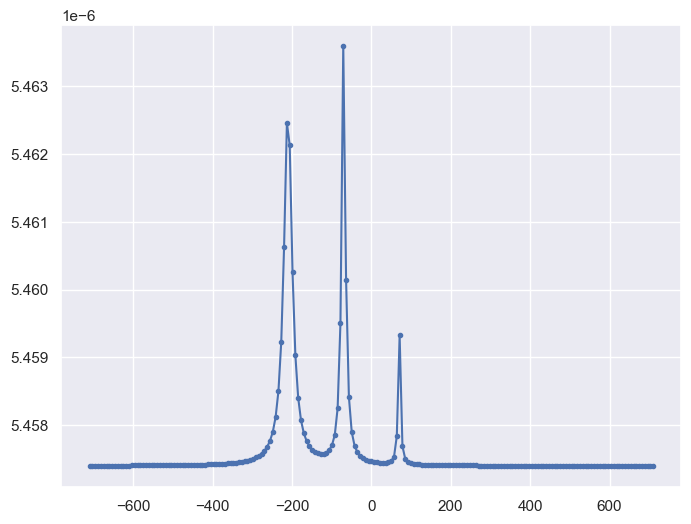

In [14]:
exc_state = get_excited_state_pops(res_ss)
plt.plot(mw_detunings/(2e3*pi), exc_state, label=fr"""$B_{{mw}}$ = 1e-4 G""", marker=".")


In [15]:
rot_angles = [faraday_rot_angle(rho=r) for r in res_ss]

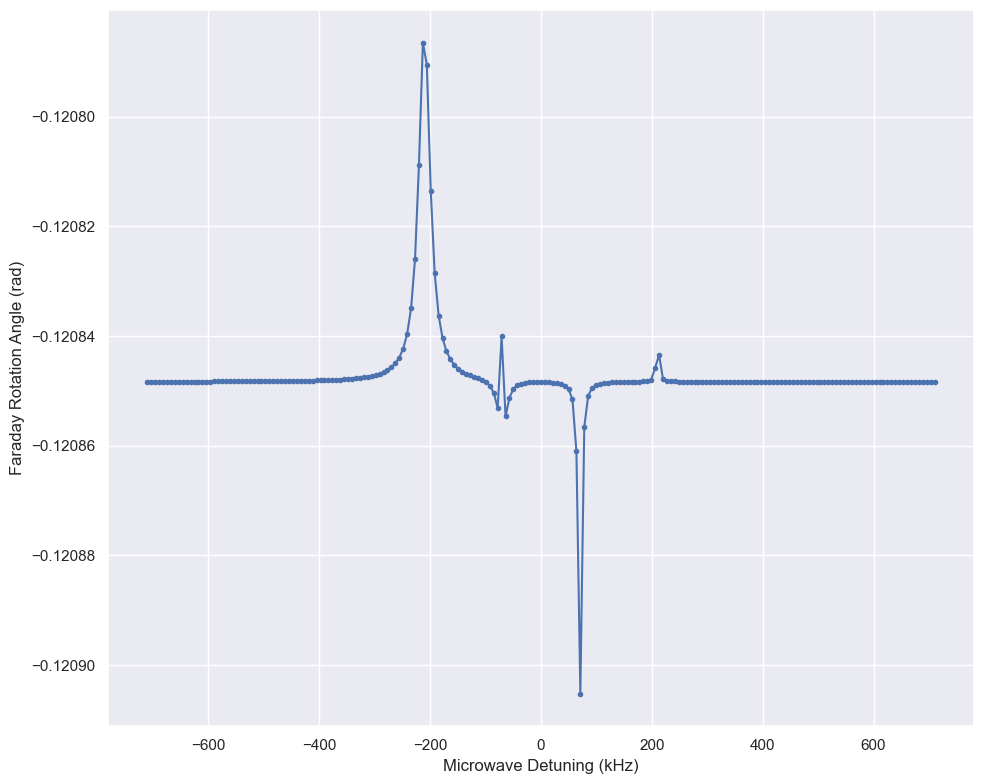

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(mw_detunings/(2e3*pi), rot_angles, marker=".")
ax.set_xlabel(r"Microwave Detuning (kHz)")
ax.set_ylabel("Faraday Rotation Angle (rad)")
plt.tight_layout()
# fig.savefig("faraday_angle_spec.png")

In [17]:
res_ss = run_simulation_exp(mw_magnetic_field=1e-5)

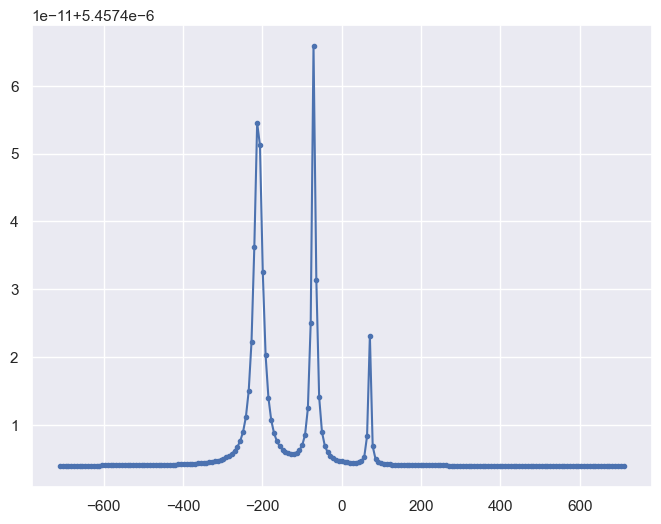

In [18]:
exc_state = get_excited_state_pops(res_ss)
plt.plot(mw_detunings/(2e3*pi), exc_state, label=fr"""$B_{{mw}}$ = 1e-5 G""", marker=".")


In [19]:
rot_angles = [faraday_rot_angle(rho=r) for r in res_ss]

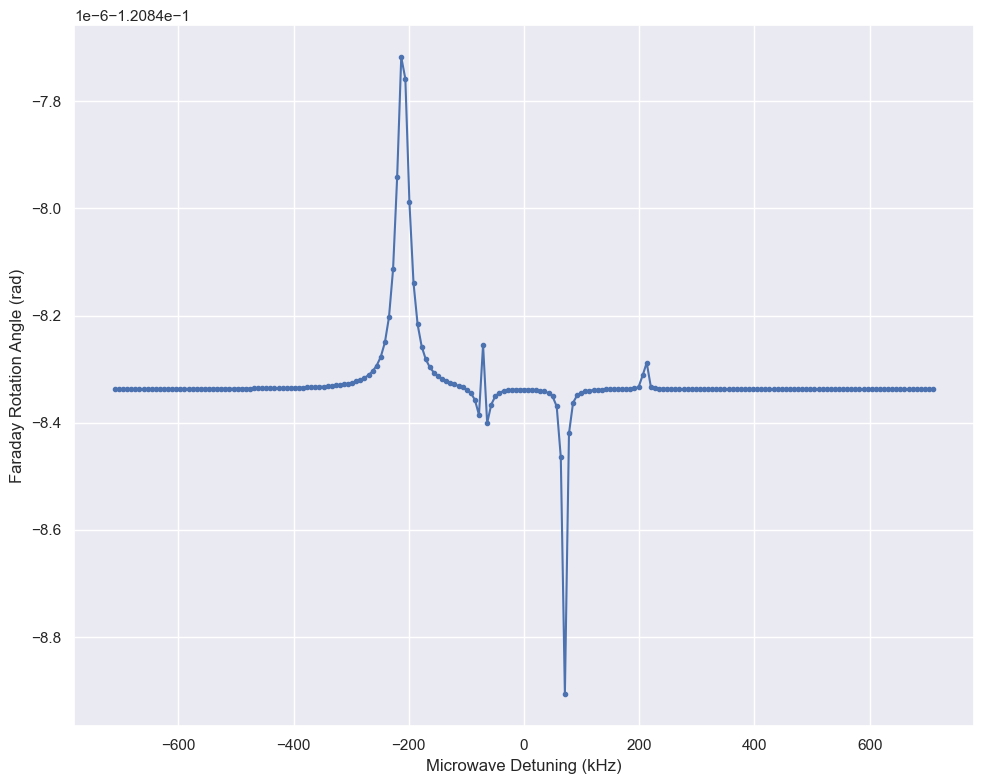

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(mw_detunings/(2e3*pi), rot_angles, marker=".")
ax.set_xlabel(r"Microwave Detuning (kHz)")
ax.set_ylabel("Faraday Rotation Angle (rad)")
plt.tight_layout()
# fig.savefig("faraday_angle_spec.png")

## Stronger MW

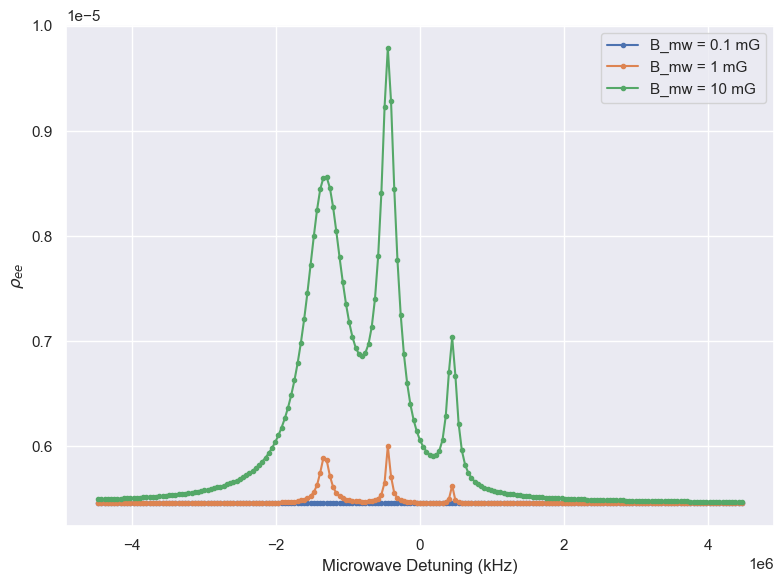

In [21]:
rhos_stronger_mw = run_simulation_exp(1e-3)
rhos_even_stronger_mw = run_simulation_exp(1e-2)
excs = get_excited_state_pops(rhos_stronger_mw)
excs1 = get_excited_state_pops(rhos_even_stronger_mw)
exc = get_excited_state_pops(run_simulation_exp(1e-4))
plt.plot(mw_detunings, exc, marker=".", label="B_mw = 0.1 mG")
plt.plot(mw_detunings, excs, marker=".", label="B_mw = 1 mG")
plt.plot(mw_detunings, excs1, marker=".", label="B_mw = 10 mG")
plt.legend()
plt.xlabel(r"Microwave Detuning (kHz)")
plt.ylabel(r"$\rho_{ee}$")
plt.tight_layout()


# Faraday Rot stronger pump

In [22]:
res_ss = run_simulation_exp(mw_magnetic_field=1e-5, laser_intens=OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL*3)

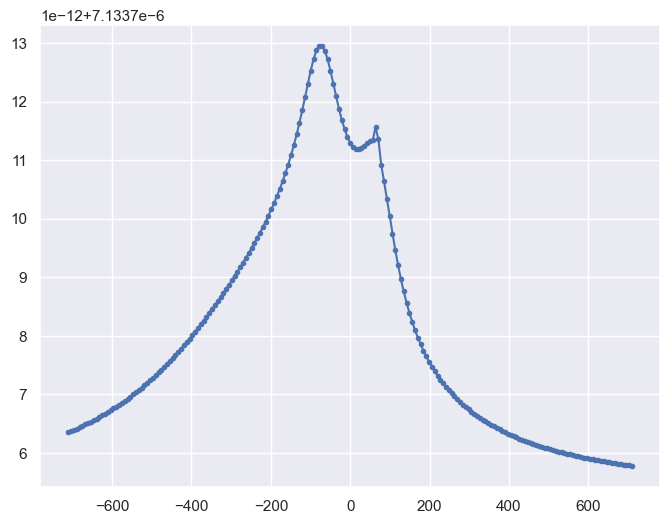

In [23]:
exc_state = get_excited_state_pops(res_ss)
plt.plot(mw_detunings/(2e3*pi), exc_state, label=fr"""$B_{{mw}}$ = 1e-5 G""", marker=".")


In [24]:
rot_angles = [faraday_rot_angle(rho=r) for r in res_ss]

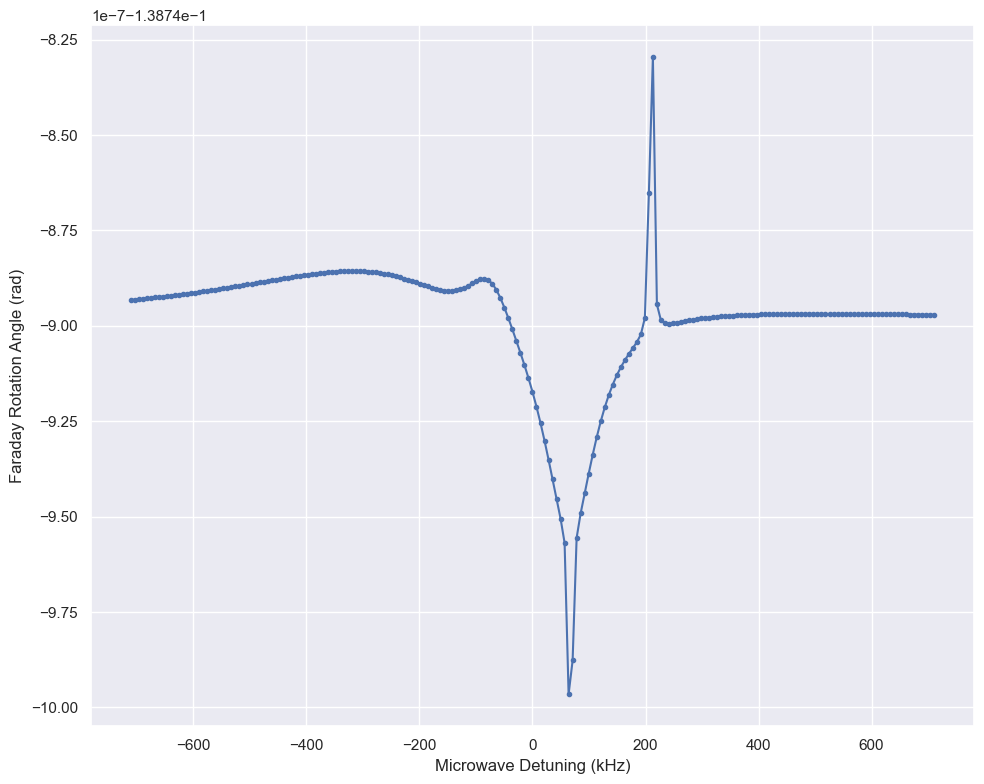

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(mw_detunings/(2e3*pi), rot_angles, marker=".")
ax.set_xlabel(r"Microwave Detuning (kHz)")
ax.set_ylabel("Faraday Rotation Angle (rad)")
plt.tight_layout()
# fig.savefig("faraday_angle_spec.png")

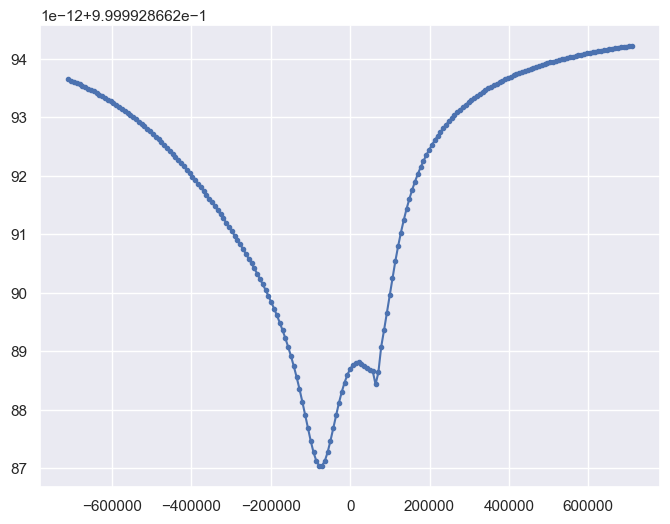

In [26]:
ground_states = [sum(state.diag()[:8]) for state in res_ss]
plt.plot(mw_detunings/(2*pi), ground_states, marker=".")

(<Figure size 800x600 with 2 Axes>,
 [<AxesSubplot:title={'center':'F=2'}>, <AxesSubplot:title={'center':'F=1'}>])

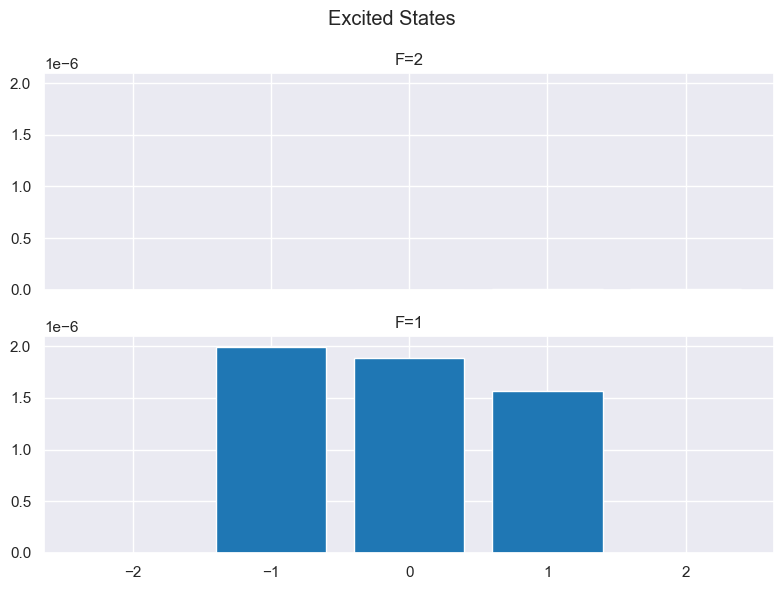

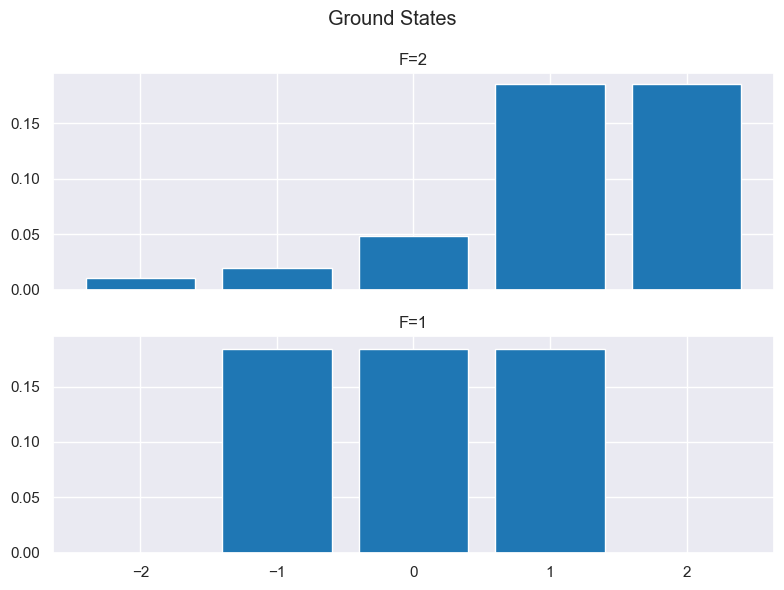

In [27]:
rho_ss_laser = steadystate(hamil(0, b_longitudinal=0, mw_mag_field=0, laser_intens=1e-1*OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL), c_op_list=decays)
def plot_bar_excited_pop_D1(rho):
    # populations plot
    fig, [ax1, ax2] = plt.subplots(nrows=2, sharey="all", sharex="all")
    ax2.bar(list(range(-1, 2)), rho.diag().real[8:3+8], color="tab:blue")
    ax1.set_title("F=2")
    ax1.bar(list(range(-2, 3)), rho.diag().real[3+8:8+8], color="tab:blue")
    ax2.set_title("F=1")
    fig.suptitle("Excited States")
    plt.tight_layout()
    return fig, [ax1, ax2]
plot_bar_excited_pop_D1(rho_ss_laser)
plot_bar_ground_pop(rho_ss_laser)

(<Figure size 800x600 with 2 Axes>,
 [<AxesSubplot:title={'center':'F=2'}>, <AxesSubplot:title={'center':'F=1'}>])

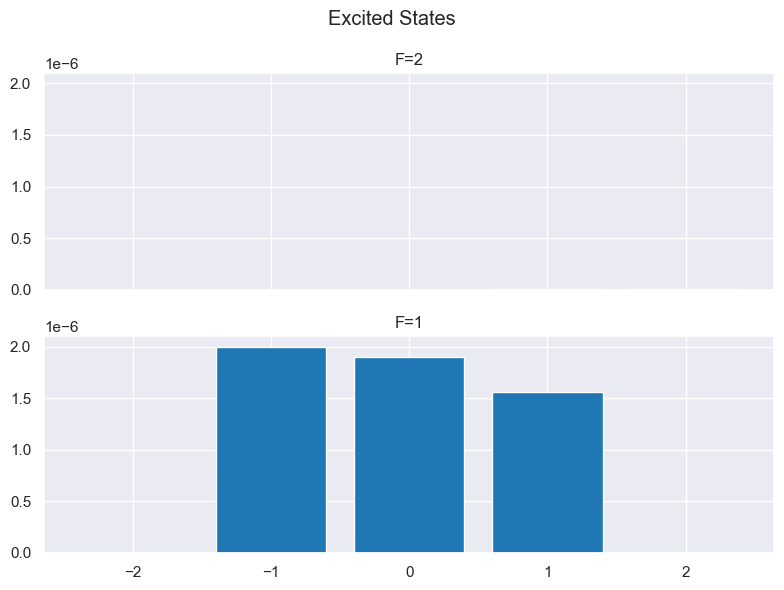

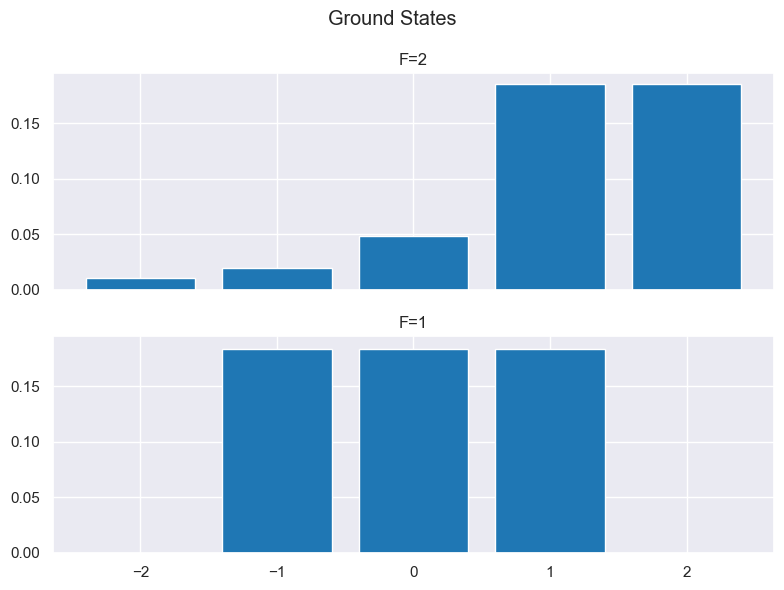

In [28]:
rho_ss = steadystate(hamil(ham_tot.diag()[6]-ham_tot.diag()[1], b_longitudinal=0, mw_mag_field=1e-4, laser_intens=1e-1*OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL), c_op_list=decays)
def plot_bar_excited_pop_D1(rho):
    # populations plot
    fig, [ax1, ax2] = plt.subplots(nrows=2, sharey="all", sharex="all")
    ax2.bar(list(range(-1, 2)), rho.diag().real[8:3+8], color="tab:blue")
    ax1.set_title("F=2")
    ax1.bar(list(range(-2, 3)), rho.diag().real[3+8:8+8], color="tab:blue")
    ax2.set_title("F=1")
    fig.suptitle("Excited States")
    plt.tight_layout()
    return fig, [ax1, ax2]
plot_bar_excited_pop_D1(rho_ss)
plot_bar_ground_pop(rho_ss)

## Difference

(<Figure size 800x600 with 2 Axes>,
 [<AxesSubplot:title={'center':'F=2'}>, <AxesSubplot:title={'center':'F=1'}>])

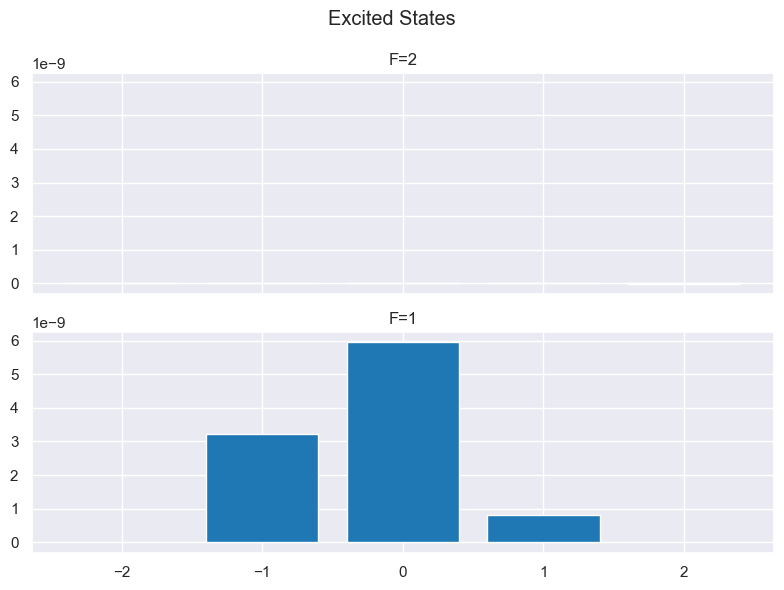

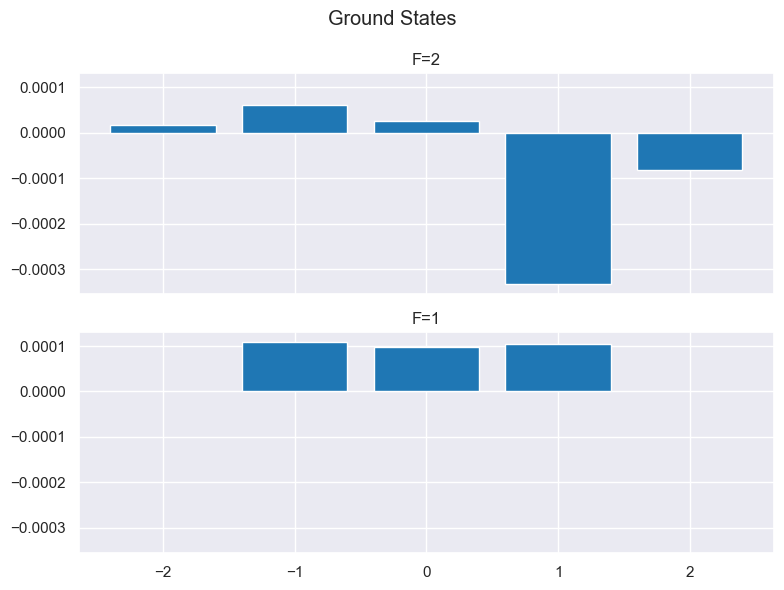

In [29]:
plot_bar_excited_pop_D1(rho_ss-rho_ss_laser)
plot_bar_ground_pop(rho_ss-rho_ss_laser)